# Question Analysis

In this notebook, the following correlations are analyzed.
- Question type and score sum of each KI
- Question sector and score sum of each KI
- QUestion sector and each question type's score sum for each KI

The method is a simple multivariable linear regression so that the $R^2$ score and regression coefficient can be interpreted as a correlation degree and contribution of each feature, respectively. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [4]:
path = r'..\data\merged\master.pickle'

In [5]:
# Import all the data & basic process
df = pd.read_pickle(path)
df.replace(['nan'], np.nan, inplace=True)
df['value'] = df['value'].astype(float)
df['value_abs'] = df['value'].abs()
df.set_index('code', inplace=True)

In [6]:
df.head()

pilot                                           variable  value  \
code                                                                      
cki_001   agh   adult_member_cal_//_all_//_demographic_//_number  -0.30   
cki_001   agh  adults_own_tazkira_1_3_3_//_all_//_demographic...   0.00   
cki_001   agh  average_montly_income_4_1_//_all_//_livelihood...  -0.15   
cki_001   agh  average_spenditure_4_4_._agri_and_livestock_//...  -1.00   
cki_001   agh  average_spenditure_4_4_._education_//_all_//_l...  -0.70   

                                                     check  \
code                                                         
cki_001               hh_db = 3.27 [3.14;3.4] vs ki_db = 2   
cki_001              hh_db = 2.01 [1.93;2.09] vs ki_db = 2   
cki_001  hh_db = 10675.31 [10323.45;11027.17] vs ki_db ...   
cki_001           hh_db = 26.51 [13.16;39.85] vs ki_db = 0   
cki_001        hh_db = 260.81 [226.14;295.49] vs ki_db = 0   

                                            question type_question   QType  \
code                                                                         
cki_001                             adult_member_cal        number  number   
cki_001                     adults_own_tazkira_1_3_3        number  number   
cki_001                    average_montly_income_4_1        number  number   
cki_001  average_spenditure_4_4_._agri_and_livestock        number  number   
cki_001           average_spenditure_4_4_._education        number  number   

        question_population question_sector quartier  ...  \
code                                                  ...   
cki_001                 all     demographic    kabul  ...   
cki_001                 all     demographic    kabul  ...   
cki_001                 all      livelihood    kabul  ...   
cki_001                 all      livelihood    kabul  ...   
cki_001                 all      livelihood    kabul  ...   

                                                       Key level comment  \
code                                                                       
cki_001                                   adult_member_cal   NaN     NaN   
cki_001                           adults_own_tazkira_1_3_3   NaN     NaN   
cki_001                                 average_income_4_1   NaN     NaN   
cki_001  x_4_4_how_much_did_the_following_essentials_._...   NaN     NaN   
cki_001  x_4_4_how_much_did_the_following_essentials_._...   NaN     NaN   

                                                   Key_bck inwomen  \
code                                                                 
cki_001                                   adult_member_cal     NaN   
cki_001                           adults_own_tazkira_1_3_3     NaN   
cki_001                                 average_income_4_1     NaN   
cki_001  x_4_4_how_much_did_the_following_essentials_._...     NaN   
cki_001  x_4_4_how_much_did_the_following_essentials_._...     NaN   

                                    ki_data         indicator polarise  \
code                                                                     
cki_001                   2-/-3-/-4-/-6-/-8  household_number  neutral   
cki_001                   2-/-3-/-5-/-6-/-8           tazkira    under   
cki_001  5000-/-7500-/-9000-/-18000-/-20000    monthly_income    under   
cki_001                                   0     income_source  neutral   
cki_001        0-/-500-/-1000-/-1500-/-2000       expenditure    under   

               Unnamed: 20 value_abs  
code                                  
cki_001  0.608252427184466      0.30  
cki_001  0.436893203883495      0.00  
cki_001  0.394660194174757      0.15  
cki_001                NaN      1.00  
cki_001  0.907766990291262      0.70  

[5 rows x 33 columns]

## Number of each question type

Generate the dataset with score sum and number of each question type that KIs were asekd

In [7]:
# Generate an additional dataframe of the number of each question type
df_code_type = df.groupby(['code','type'])
df_gr = df_code_type.count()['variable']
KI_by_question_type = df_gr.reset_index().pivot(columns='type', index='code', values='variable')

In [8]:
df_gr

code        type      
cki042_001  number        17
            percentage    13
            rank           6
            rank1         23
cki042_002  number        19
                          ..
wki_035     rank           1
            rank1          5
wki_036     percentage     1
            rank           1
            rank1          5
Name: variable, Length: 14168, dtype: int64

In [9]:
# New data frame of score sum for each KI
new_df = df.groupby('code')['value_abs'].sum() # SUM / MEAN
new_df = pd.DataFrame(new_df)
new_df=new_df.rename(columns={'value_abs':'value_abs_sum'})

In [10]:
# Merge it with the additional df
new_df = new_df.merge(KI_by_question_type, how='left', left_index=True, right_index=True)
new_df = new_df.fillna(0)

In [11]:
# Check missing values
new_df.isnull().sum() 

value_abs_sum    0
number           0
ordinal          0
percentage       0
rank             0
rank1            0
rank_integer     0
rankperc         0
dtype: int64

Preparing the dataset for the linear regression and perform it

In [12]:
X = new_df.drop(columns='value_abs_sum')
y = new_df[['value_abs_sum']]

In [13]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [14]:
# In this analysis, no scaler was used. 
#scaler = StandardScaler()
#x_pre = scaler.fit_transform(x_train)

In [15]:
line_fitter = LinearRegression()
line_fitter.fit(x_train, y_train)

y_predict = line_fitter.predict(x_test)

The $R^2$ score of 0.87 implies that the question type has a correlation with the score sum.

Score : 0.8655796719821919


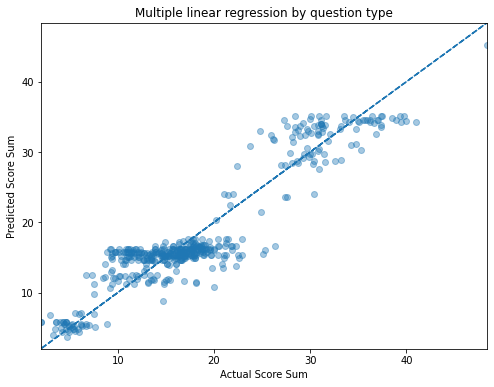

In [16]:
minval = float(y_test.min())
maxval = float(y_test.max())

print('Score :', line_fitter.score(x_test, y_test))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_predict, alpha=0.4)
plt.plot(y_test, y_test, '--')
plt.xlabel("Actual Score Sum")
plt.ylabel("Predicted Score Sum")
plt.title("Multiple linear regression by question type")
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.show()

From the regression coefficients
- Easiest question type: Percentage
- Hardest question type: Rank1

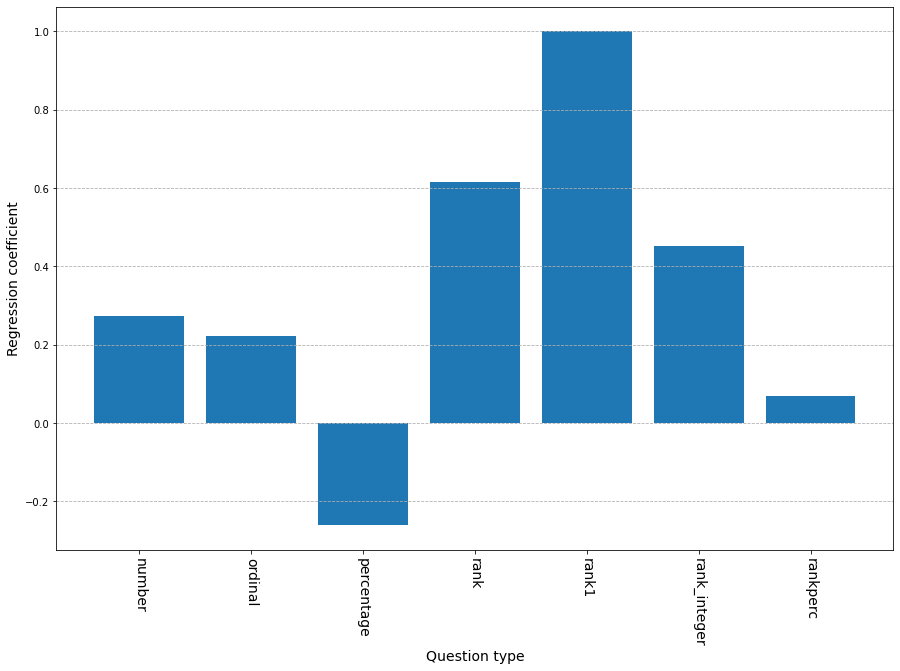

In [17]:
plt.figure(figsize=(15,10))
plt.bar(new_df.drop(columns="value_abs_sum").columns,line_fitter.coef_.flatten())
plt.xlabel('Question type', fontsize=14)
plt.ylabel('Regression coefficient', fontsize=14)
plt.xticks(rotation=270, fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.show()


## Number of each sector

Likewise the correlation between question sectors and the score sum can be analyzed, by generating a table with the number of each question type and score sum.

In [18]:
# Generate an additional dataframe of the number of each question type
df_code_sector = df.groupby(['code','question_sector'])
df_gr = df_code_sector.count()['variable']
KI_by_sector = df_gr.reset_index().pivot(columns='question_sector', index='code', values='variable')

In [19]:
# New data frame of score sum for each KI
df_new = df.groupby('code')['value_abs'].sum()    # SUM/MEAN switch
df_new = pd.DataFrame(df_new)
df_new=df_new.rename(columns={'value_abs':'value_abs_sum'})

Among sectors, the 'assistance' sector was excluded because it exhibits too much impact on the correlation analysis although it carries very less information based on the preliminary analysis. 

In [20]:
# Merge it with the additional df
df_new = df_new.merge(KI_by_sector, how='left', left_index=True, right_index=True)
df_new = df_new.fillna(0)
df_new = df_new.drop(columns='assistance')

In [21]:
df_new.head()

value_abs_sum  demographic  displacement  education  food  health  \
code                                                                            
cki042_001          28.15         11.0           4.0        0.0   0.0    17.0   
cki042_002          27.90         11.0           4.0        0.0   0.0    18.0   
cki042_003          29.15         11.0           4.0        0.0   0.0    18.0   
cki042_004          29.80         11.0           4.0        0.0   0.0    18.0   
cki042_005          30.10         11.0           4.0        0.0   0.0    18.0   

            livelihood  shelter  wash  
code                                   
cki042_001        15.0      0.0   9.0  
cki042_002        16.0      0.0   9.0  
cki042_003        16.0      0.0  10.0  
cki042_004        15.0      0.0   9.0  
cki042_005        15.0      0.0   9.0

Perform linear regression.

In [22]:
X = df_new.drop(columns='value_abs_sum')
y = df_new[['value_abs_sum']]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
line_fitter = LinearRegression()
line_fitter.fit(x_train, y_train)

y_predict = line_fitter.predict(x_test)

Question sectors have as significant $R^2$ score as question types.

Score:  0.863276433289373


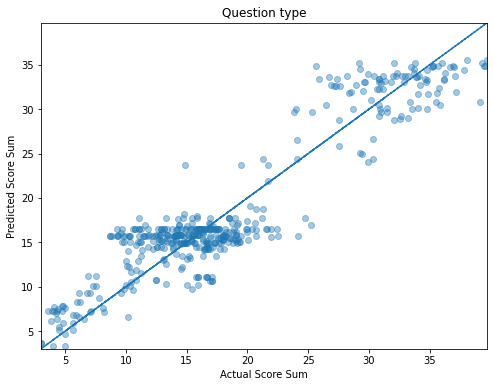

In [24]:
minval = float(y_test.min())
maxval = float(y_test.max())

print('Score: ', line_fitter.score(x_test, y_test))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_predict, alpha=0.4)
plt.plot(y_test, y_test, '--')
plt.xlabel("Actual Score Sum")
plt.ylabel("Predicted Score Sum")
plt.title("Question type")
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.show()

Among question types,
- The easiest: food
- The hardest: displacement

However, the regression coefficient of the rest sectors do not highly deviate unlike question types.  

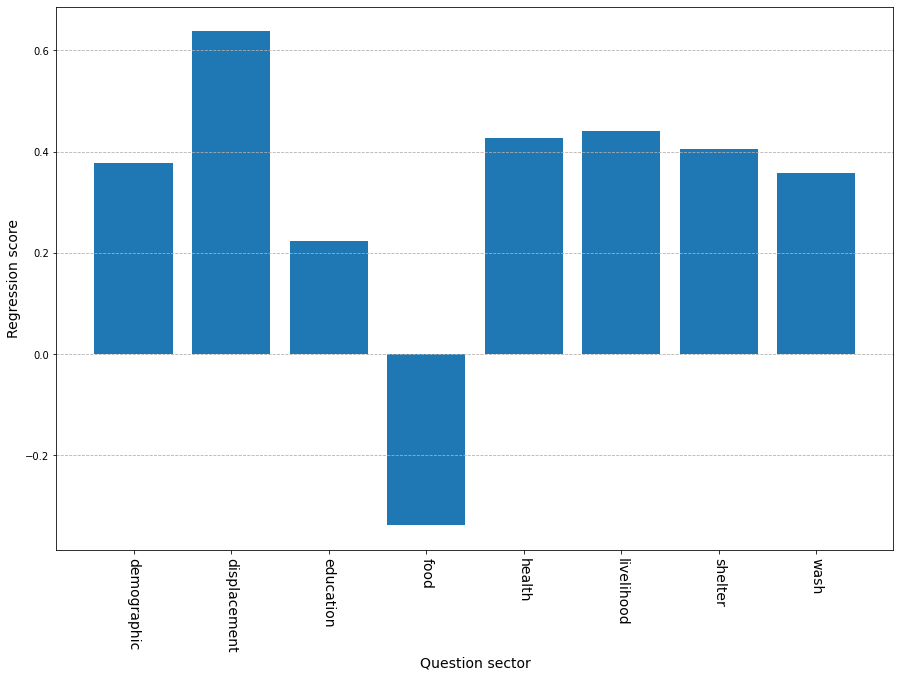

In [25]:
# For all KIs - train/test
plt.figure(figsize=(15,10))
plt.bar(df_new.drop(columns="value_abs_sum").columns,line_fitter.coef_.flatten())
plt.xticks(rotation=-90, fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.ylabel('Regression score', fontsize=14)
plt.xlabel('Question sector', fontsize=14)
plt.show()


## Score sum by type

By observing the correlation between quetion type, sector and score sum, an additional analysis on correlation between question sectors and score sum of each question type for individual KI can be performed. 
(Please refer the the report for more specific discussion of this section.)

In [26]:
df_score_by_sector=df.groupby(['code','type']).sum()['value_abs'].reset_index().pivot(columns='type', index='code', values='value_abs')
df_score_by_sector = df_score_by_sector.fillna(0)

In [27]:
df_score_by_sector.head()

type        number  ordinal  percentage  rank  rank1  rank_integer  rankperc
code                                                                        
cki042_001    7.50      0.0        0.85   2.8   17.0           0.0       0.0
cki042_002    7.70      0.0        1.10   3.1   16.0           0.0       0.0
cki042_003    7.25      0.0        1.30   1.6   19.0           0.0       0.0
cki042_004    8.65      0.0        1.65   2.5   17.0           0.0       0.0
cki042_005    8.20      0.0        1.10   2.8   18.0           0.0       0.0

Result of the question type number
0.6779060182351913


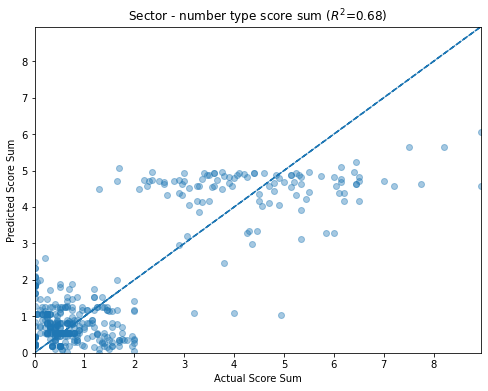

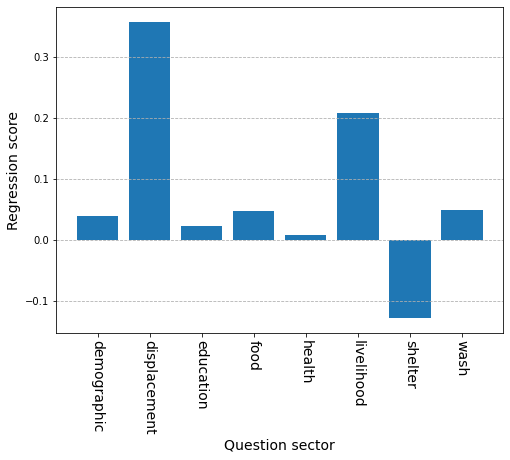

----------------------------------------------------------
Result of the question type ordinal
0.7168775490564683


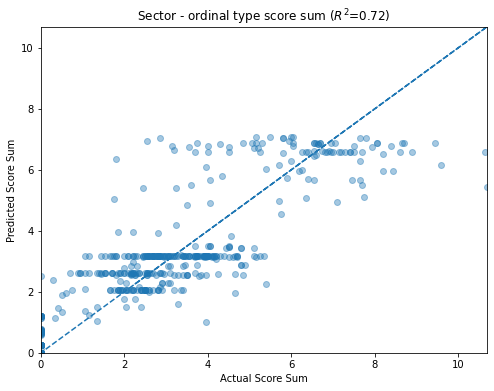

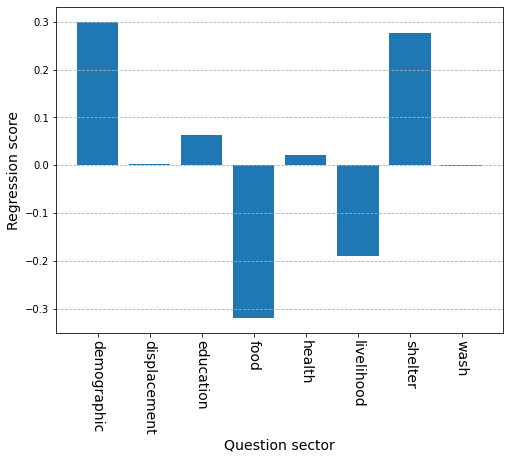

----------------------------------------------------------
Result of the question type percentage
0.7536611679404986


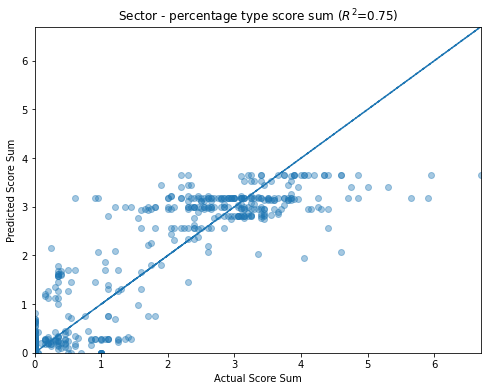

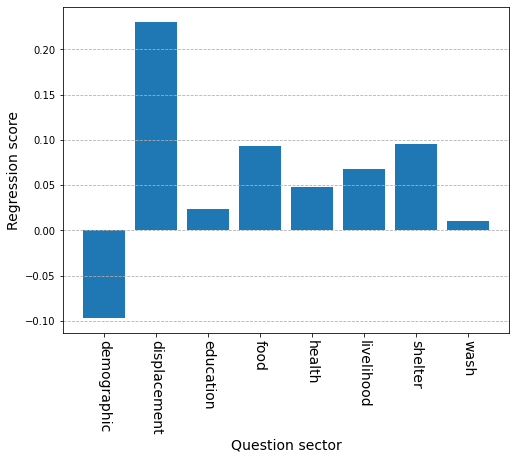

----------------------------------------------------------
Result of the question type rank
0.8019556397405955


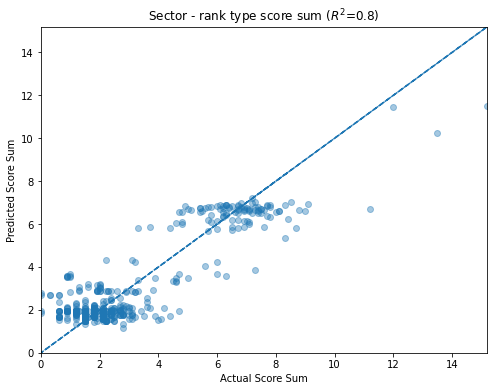

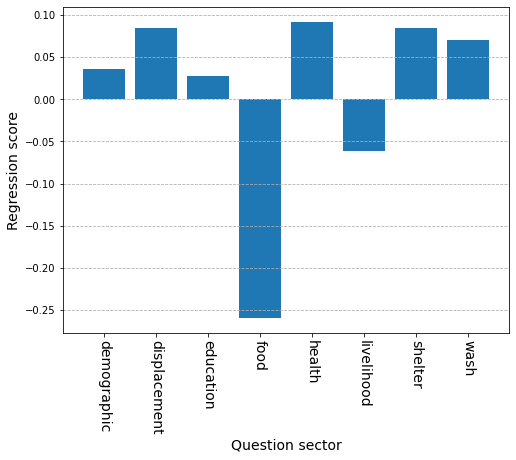

----------------------------------------------------------
Result of the question type rank1
0.4986636450471641


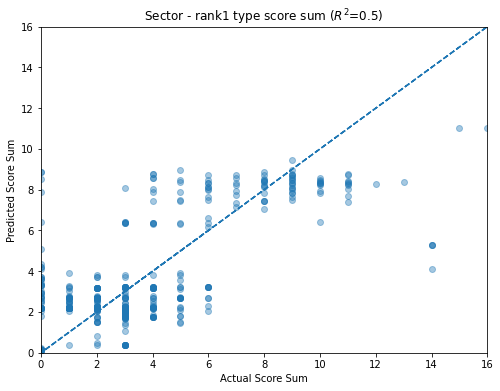

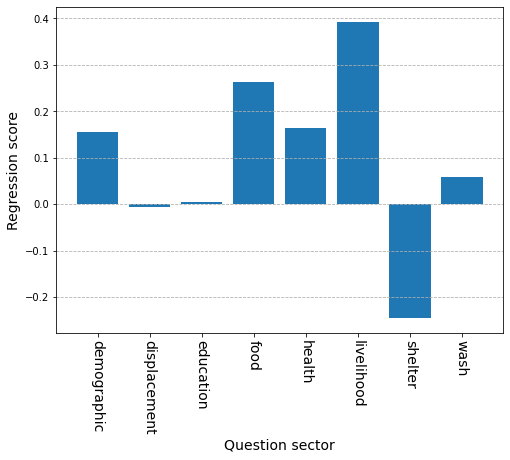

----------------------------------------------------------
Result of the question type rank_integer
0.6682974662058083


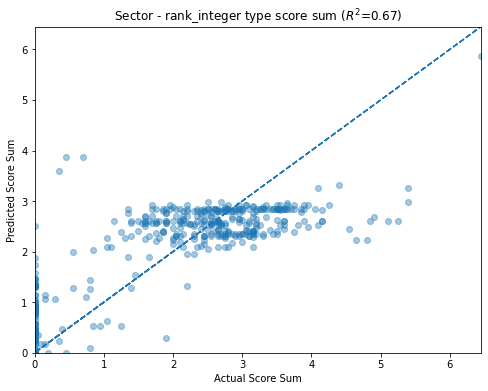

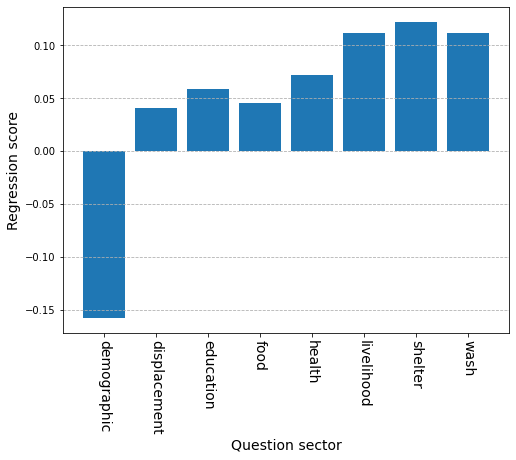

----------------------------------------------------------
Result of the question type rankperc
0.6414100277334756


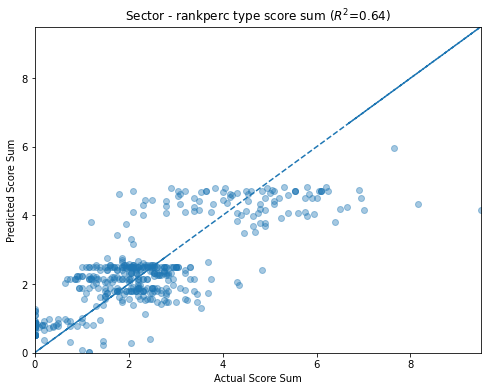

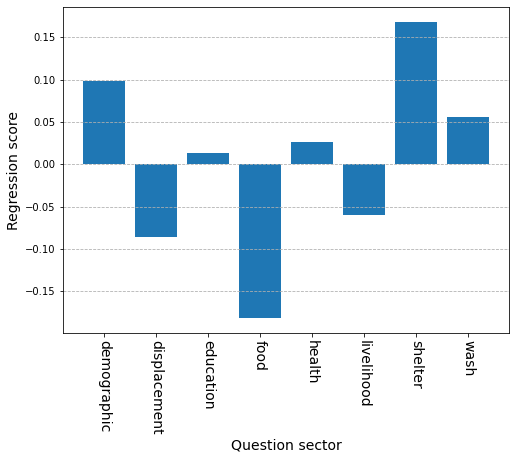

----------------------------------------------------------


In [28]:
# Score sum by sector vs Edge

for c in df_score_by_sector.columns:
    print('Result of the question type', c)
    
    temp_df = df_score_by_sector.copy()
    ddf = df_new.drop(columns='value_abs_sum')
    ddf = ddf.merge(temp_df[c], how='inner', left_index=True, right_index=True)
    #ddf = ddf.drop(columns=['assistance'])
    
    X = ddf.drop(columns=c)
    y = ddf[c]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
    line_fitter = LinearRegression()
    line_fitter.fit(x_train, y_train)

    y_predict = line_fitter.predict(x_test)
    y_predict[y_predict<0] = 0
    
    print(line_fitter.score(x_test, y_test))
    s = float("%.2f" % line_fitter.score(x_test, y_test))
    minval = float(y_test.min())
    maxval = float(y_test.max())
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_predict, alpha=0.4)
    plt.plot(y_test, y_test, '--')
    plt.xlabel("Actual Score Sum")
    plt.ylabel("Predicted Score Sum")
    plt.title("Sector - {} type score sum ($R^2$={})".format(c, s))
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.bar(df_new.drop(columns="value_abs_sum").columns,line_fitter.coef_.flatten())
    plt.xticks(rotation=-90, fontsize=14)
    plt.grid(axis='y', linestyle='--')
    plt.ylabel('Regression score', fontsize=14)
    plt.xlabel('Question sector', fontsize=14)
    plt.show()
    
    print('----------------------------------------------------------')
    